# Demo of MUMBO for multi-fidelity Bayesian Optimisation

This notebook provides a demo of the MUlti-task Max-value Bayesian Optimisation (MUMBO) acquisition function of Moss et al [2020].
https://arxiv.org/abs/2006.12093

MUMBO provides the high perfoming optimization of other entropy-based acquisitions. However, unlike the standard entropy-search for multi-fidelity optimization, MUMBO requires a fraction of the computational cost. MUMBO is a multi-fidelity (or multi-task) extension of max-value entropy search also availible in Emukit.

Our implementation of MUMBO is controlled by two parameters: "num_samples" and "grid_size". "num_samples" controls how many mote-carlo samples we use to calculate entropy reductions. As we only approximate a 1-d integral, "num_samples" does not need to be large or be increased for problems with large d (unlike standard entropy-search). We recomend values between 5-15. "grid_size" controls the coarseness of the grid used to approximate the distribution of our max value and so must increase with d. We recommend 10,000*d. Note that as the grid must only be calculated once per BO step, the choice of "grid_size" does not have a large impact on computation time.  


In [1]:
### General imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import GPy
import time
np.random.seed(12345)

### Emukit imports
from emukit.test_functions.forrester import multi_fidelity_forrester_function
from emukit.core.loop.user_function import UserFunctionWrapper
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array
from emukit.bayesian_optimization.acquisitions.entropy_search import MultiInformationSourceEntropySearch
from emukit.bayesian_optimization.acquisitions.max_value_entropy_search import MUMBO
from emukit.core.acquisition import Acquisition
from emukit.multi_fidelity.models.linear_model import GPyLinearMultiFidelityModel
from emukit.multi_fidelity.kernels.linear_multi_fidelity_kernel import LinearMultiFidelityKernel
from emukit.multi_fidelity.convert_lists_to_array import convert_xy_lists_to_arrays
from emukit.core import ParameterSpace, ContinuousParameter, InformationSourceParameter
from emukit.model_wrappers import GPyMultiOutputWrapper
from GPy.models.gp_regression import GPRegression


### --- Figure config
LEGEND_SIZE = 15

Set up our toy problem (1D optimisation of the forrester function with two fidelity levels) and collect 6 initial points at low fidelity and 3 at high fidelitly. 

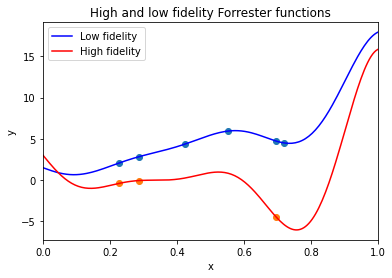

In [2]:
# Load function
# The multi-fidelity Forrester function is already wrapped as an Emukit UserFunction object in 
# the test_functions package
forrester_fcn, _ = multi_fidelity_forrester_function()
forrester_fcn_low = forrester_fcn.f[0]
forrester_fcn_high = forrester_fcn.f[1]

# Assign costs
low_fidelity_cost = 1
high_fidelity_cost = 10

# Plot the function s
x_plot = np.linspace(0, 1, 200)[:, None]
y_plot_low = forrester_fcn_low(x_plot)
y_plot_high = forrester_fcn_high(x_plot)
plt.plot(x_plot, y_plot_low, 'b')
plt.plot(x_plot, y_plot_high, 'r')
plt.legend(['Low fidelity', 'High fidelity'])
plt.xlim(0, 1)
plt.title('High and low fidelity Forrester functions')
plt.xlabel('x')
plt.ylabel('y');


# Collect and plot initial samples
np.random.seed(123)
x_low = np.random.rand(6)[:, None]
x_high = x_low[:3]
y_low = forrester_fcn_low(x_low)
y_high = forrester_fcn_high(x_high)
plt.scatter(x_low,y_low)
plt.scatter(x_high,y_high)

Fit our linear multi-fidelity GP model to the observed data. 

In [3]:
x_array, y_array = convert_xy_lists_to_arrays([x_low, x_high], [y_low, y_high])

kern_low = GPy.kern.RBF(1)
kern_low.lengthscale.constrain_bounded(0.01, 0.5)

kern_err = GPy.kern.RBF(1)
kern_err.lengthscale.constrain_bounded(0.01, 0.5)

multi_fidelity_kernel = LinearMultiFidelityKernel([kern_low, kern_err])
gpy_model = GPyLinearMultiFidelityModel(x_array, y_array, multi_fidelity_kernel, 2)

gpy_model.likelihood.Gaussian_noise.fix(0.1)
gpy_model.likelihood.Gaussian_noise_1.fix(0.1)

model = GPyMultiOutputWrapper(gpy_model, 2, 5, verbose_optimization=False)
model.optimize()

reconstraining parameters rbf.lengthscale
reconstraining parameters rbf.lengthscale


Define acqusition functions for multi-fidelity problems

In [4]:
# Define cost of different fidelities as acquisition function
class Cost(Acquisition):
    def __init__(self, costs):
        self.costs = costs

    def evaluate(self, x):
        fidelity_index = x[:, -1].astype(int)
        x_cost = np.array([self.costs[i] for i in fidelity_index])
        return x_cost[:, None]
    
    @property
    def has_gradients(self):
        return True
    
    def evaluate_with_gradients(self, x):
        return self.evalute(x), np.zeros(x.shape)

parameter_space = ParameterSpace([ContinuousParameter('x', 0, 1), InformationSourceParameter(2)])
cost_acquisition = Cost([low_fidelity_cost, high_fidelity_cost])
es_acquisition = MultiInformationSourceEntropySearch(model, parameter_space) / cost_acquisition
mumbo_acquisition = MUMBO(model, parameter_space, num_samples=5, grid_size=500) / cost_acquisition

Lets plot the resulting acqusition functions (MUMBO and standard entropy search for multi-fidelity BO) for the chosen model on the collected data. Note that MES takes a fraction of the time of ES to compute (plotted on a log scale). This difference becomes even more apparent as you increase the dimensions of the sample space.

Text(0, 0.5, 'Calculation Time (secs)')

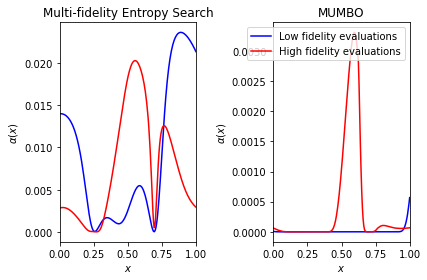

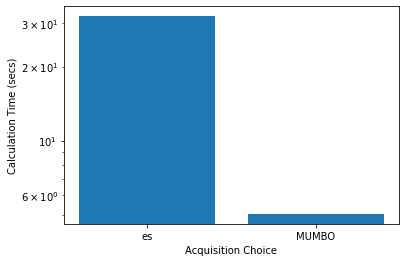

In [5]:
x_plot_low = np.concatenate([np.atleast_2d(x_plot), np.zeros((x_plot.shape[0], 1))], axis=1)
x_plot_high = np.concatenate([np.atleast_2d(x_plot), np.ones((x_plot.shape[0], 1))], axis=1)
t_0=time.time()
es_plot_low = es_acquisition.evaluate(x_plot_low)
es_plot_high = es_acquisition.evaluate(x_plot_high)
t_es=time.time()-t_0
mumbo_plot_low = mumbo_acquisition.evaluate(x_plot_low)
mumbo_plot_high = mumbo_acquisition.evaluate(x_plot_high)
t_mumbo=time.time()-t_es-t_0

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x_plot, es_plot_low , "blue")
ax1.plot(x_plot, es_plot_high, "red")
ax1.set_title("Multi-fidelity Entropy Search")
ax1.set_xlabel(r"$x$")
ax1.set_ylabel(r"$\alpha(x)$")
ax1.set_xlim(0, 1)

ax2.plot(x_plot, mumbo_plot_low , "blue", label="Low fidelity evaluations")
ax2.plot(x_plot, mumbo_plot_high , "red",label="High fidelity evaluations")
ax2.legend(loc="upper right")
ax2.set_title("MUMBO")
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$\alpha(x)$")
ax2.set_xlim(0, 1)
plt.tight_layout()
plt.figure()
plt.bar(["es","MUMBO"],[t_es,t_mumbo])
plt.xlabel("Acquisition Choice")
plt.yscale('log')
plt.ylabel("Calculation Time (secs)")
